# **Imports**

In [24]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import seaborn as sn

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
import torchprofile

import time
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [2]:
def save_for_plot(data, name):
    e = np.asarray(data)
    with open("./Results/"+ name + ".csv", "w") as fe:
        np.savetxt(fe, e, delimiter=",")

# **Data**

In [3]:
dataHandler = getData(0.1)

Training:  (340200, 2, 128) (340200, 2)
Validation:  (37800, 2, 128) (37800, 2)
Testing:  (42000, 2, 128) (42000, 2)


In [4]:
trainLoader, valLoader, testLoader = dataHandler.get_loaders()

# **Baseline Model**

In [5]:
NUM_EPOCHS = 50

In [6]:
bl_initialWeights = "./models/intialized_bl_0420.pth"
blNet = blModel().to(device)
blNet.load_state_dict(torch.load(bl_initialWeights))
optimizer_bl = optim.Adam(blNet.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer_bl, 50, verbose=True)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

Adjusting learning rate of group 0 to 1.0000e-04.


In [7]:
bl_titleToday = "./models/best_bl_0502.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
#blNet, blHistory = BL.train(trainLoader, valLoader)
#blNet.load_state_dict(torch.load("./models/best_bl_0426.pth"))
blNet.load_state_dict(torch.load(bl_titleToday))

<All keys matched successfully>

# **EE Model**

In [8]:
eeV0_initialWeights = "./models/intialized_eeV0_0424_after.pth"
eeV1_initialWeights = "./models/intialized_eeV1_0424_after.pth"
eeV2_initialWeights = "./models/intialized_eeV4_0501_after.pth"
eeV3_initialWeights = "./models/intialized_eeV3_0504"

## Training V0

In [9]:
V0_titleToday = "./models/Final/best_eeV0.pth"
eeNet_V0 = eeModel_V0().to(device)
eeNet_V0.load_state_dict(torch.load(eeV0_initialWeights))

optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V0 = CosineAnnealingLR(optimizer_ee_V0, 50, verbose=True)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()

EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)
#eeNet_V0, eeHistory_V0 = EE_V0.train(trainLoader, valLoader)
eeNet_V0.load_state_dict(torch.load(V0_titleToday))

Number of base parameters: 576
Number of short branch parameters: 68010
Number of long branch parameters: 118842
Difference = 50832
Adjusting learning rate of group 0 to 1.0000e-04.


<All keys matched successfully>

In [10]:
eeRecorder_V0, preds_V0, acc_V0 = EE_V0.infer(valLoader, threshold=0.05, verbose=False)
EE_V0.testingSummary(eeRecorder_V0, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 100.00% with 1.42% of the samples
Branch 2: Accuracy 62.32% with 98.58% of the samples
Overall Weighted Accuracy: 62.86%


## Training V1

In [11]:
V1_titleToday = "./models/Final/eeV1.pth"
eeNet_V1 = eeModel_V1().to(device)
eeNet_V1.load_state_dict(torch.load(eeV1_initialWeights))

optimizer_ee_V1 = optim.Adam(eeNet_V1.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V1 = nn.CrossEntropyLoss()
scheduler_V1 = CosineAnnealingLR(optimizer_ee_V1, 50, verbose=True)
scheduler_V1 = None

EE_V1 = eeHandler(eeNet_V1, criterion_ee_V1, optimizer_ee_V1, device, scheduler=scheduler_V1, num_epochs=NUM_EPOCHS, bestPath=V1_titleToday)
#eeNet_V1, eeHistory_V1 = EE_V1.train(trainLoader, valLoader)
eeNet_V1.load_state_dict(torch.load(V1_titleToday))

Number of base parameters: 13056
Number of short branch parameters: 68010
Number of long branch parameters: 106362
Difference = 38352
Adjusting learning rate of group 0 to 1.0000e-04.


<All keys matched successfully>

In [12]:
eeRecorder_V1, preds_V1, acc_V1 = EE_V1.infer(valLoader, threshold=0.05, verbose=False)
EE_V1.testingSummary(eeRecorder_V1, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.99% with 20.82% of the samples
Branch 2: Accuracy 52.51% with 79.18% of the samples
Overall Weighted Accuracy: 62.40%


## Training V2

In [13]:
V2_titleToday = "./models/Final/eeV2.pth"

eeNet_V2 = eeModel_V2().to(device)
eeNet_V2.load_state_dict(torch.load(eeV2_initialWeights))

optimizer_ee_V2 = optim.Adam(eeNet_V2.parameters(), lr=0.0001, weight_decay=5e-4)
criterion_ee_V2 = nn.CrossEntropyLoss()
scheduler_V2 = CosineAnnealingLR(optimizer_ee_V2, 50, verbose=True)
scheduler_V2 = None

EE_V2 = eeHandler(eeNet_V2, criterion_ee_V2, optimizer_ee_V2, device, scheduler=scheduler_V2, num_epochs=NUM_EPOCHS, bestPath=V2_titleToday)
#eeNet_V2, eeHistory_V2 = EE_V2.train(trainLoader, valLoader)
eeNet_V2.load_state_dict(torch.load(V2_titleToday))

Number of base parameters: 25536
Number of short branch parameters: 68010
Number of long branch parameters: 93882
Difference = 25872
Adjusting learning rate of group 0 to 1.0000e-04.


<All keys matched successfully>

In [14]:
eeRecorder_V2, preds_V2, acc_V2 = EE_V2.infer(valLoader, threshold=0.05, verbose=False)
EE_V2.testingSummary(eeRecorder_V2, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.93% with 25.61% of the samples
Branch 2: Accuracy 47.88% with 74.39% of the samples
Overall Weighted Accuracy: 61.21%


# Training V3

In [15]:
V3_titleToday = "./models/Final/eeV3.pth"
eeNet_V3 = eeModel_V3().to(device)
eeNet_V3.load_state_dict(torch.load(eeV3_initialWeights))

optimizer_ee_V3 = optim.Adam(eeNet_V3.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_V3 = CosineAnnealingLR(optimizer_ee_V3, 50, verbose=True)
scheduler_V3 = None
criterion_ee_V3 = nn.CrossEntropyLoss()

EE_V3 = eeHandler(eeNet_V3, criterion_ee_V3, optimizer_ee_V3, device, scheduler=scheduler_V3, num_epochs=NUM_EPOCHS, bestPath=V3_titleToday)
#eeNet_V3, eeHistory_V3 = EE_V3.train(trainLoader, valLoader)
eeNet_V3.load_state_dict(torch.load(V3_titleToday))

Number of base parameters: 34944
Number of short branch parameters: 68010
Number of long branch parameters: 84474
Difference = 16464
Adjusting learning rate of group 0 to 1.0000e-04.


<All keys matched successfully>

In [16]:
eeRecorder_V3, preds_V3, acc_V3 = EE_V3.infer(valLoader, threshold=0.05, verbose=False)
EE_V3.testingSummary(eeRecorder_V3, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 99.82% with 32.10% of the samples
Branch 2: Accuracy 45.77% with 67.90% of the samples
Overall Weighted Accuracy: 63.12%


In [156]:
X, Y, Z = EE_V0.infer(testLoader, threshold=0.3, verbose=False)
EE_V0.testingSummary(X, nBranches=2, overall=True)

Summary
Branch 1: Accuracy 87.09% with 13.85% of the samples
Branch 2: Accuracy 58.39% with 86.15% of the samples
Overall Weighted Accuracy: 62.37%


# SNR

# 1 ST

In [40]:
def infer(net, sLoader, threshold=0.05, verbose=False):
    """
            @Inference: we compare the output confidence (entropy) at a branch with a certain threshold.
    """
    softmaxLayer = nn.Softmax(dim=1)
    acc = 0
    predicted, gTruths = [], []
    recorder = {x: [] for x in range(2)}
    net.eval()
    with torch.no_grad():
        for inputs, gTruth in sLoader:
            inputs, gTruth = inputs.to(device), gTruth.to(device)
            x = net.baseModel(inputs)
            for iSample in range(x.shape[0]): # a sample by sample
                out1 = net.shortBranch(x[iSample:iSample+1])
                gTruths.append(gTruth[iSample].item())
                y = softmaxLayer(out1)
                e = entropy(y.detach().cpu().numpy().squeeze(), base=10)
                if e <= threshold:
                    if verbose:
                        print(e)
                    _, label = torch.max(out1, 1)
                    predicted.append(label)
                    if label == gTruth[iSample].item():
                        recorder[0].append(1)
                        acc+=1
                    else:
                        recorder[0].append(0)
                    continue
                out2 = net.longBranch(x[iSample:iSample+1])
                _, label = torch.max(out2, 1)
                predicted.append(label)
                if label == gTruth[iSample].item():
                    acc+=1
                    recorder[1].append(1)
                else:
                    recorder[1].append(0) 
            
            acc = acc / sum([len(recorder[x]) for x in range(2)])

        return recorder, torch.FloatTensor(predicted), torch.FloatTensor(gTruths), acc

In [161]:
# Getting TRAIN data with differebt SNRs values in dB
thresholds = [0.35]
accuracies2 = {typ: {thre:{y: 0 for y in stringSNRs} for thre in thresholds} for typ in ["Baseline", "V0", "V1", "V2", "V3"]}
inferenceCounter2= {y: {thre: {x: {snr: 0 for snr in stringSNRs} for x in range(nBranches)} for thre in thresholds} for y in ["V0", "V1", "V2", "V3"]}
predictions2 = {V: {thre: {y: {'preds': 0, 'labels': 0} for y in stringSNRs} for thre in thresholds} for V in ["V0", "V1", "V2", "V3"]}
for snr in stringSNRs:
    
    tmpData = np.array([testXs[i] for i in range(len(testLabels)) if testLabels[i][1]==snr])
    tmpLabels = np.array([testLabels[i][0] for i in range(len(testLabels)) if testLabels[i][1]==snr])

    label_val = list(map(lambda x: tmpLabels[x], range(len(tmpLabels))))
    tmpLabels = np.array((list(map(lambda x: label_dict[x], label_val))))
    tmpSet = {'data': torch.tensor(tmpData).float(), 'labels': torch.tensor(tmpLabels).float()}

    tmpLoader = DataLoader(myDataset(tmpSet), batch_size= 25, shuffle = True, num_workers= 0)
    

    bl_Acc = 0
    
    with torch.no_grad():
            blNet.eval()
            for data, labels in tmpLoader:
                data, labels = data.to(device), labels.to(device)
                # Long
                outputs = blNet(data)
                _, preds = torch.max(outputs, 1)
                bl_Acc += accuracy_score(labels.detach().cpu().numpy(), preds.detach().cpu().numpy())     
                
            bl_Acc = bl_Acc/len(tmpLoader)
            
            accuracies2["Baseline"][0.35][snr] = bl_Acc  # 0.01 is just a placeholder..
    
    # Early Exiting
    for thre in thresholds:
        #recorder_V0, preds, eeAcc_V0 = EE_V0.infer(tmpLoader, threshold=thre)
        recorder_V0, preds, gTruths, eeAcc_V0 = infer(eeNet_V0, tmpLoader, threshold=thre)
        accuracies2["V0"][thre][snr] = eeAcc_V0
        predictions2["V0"][thre][snr]['preds'] = preds
        predictions2["V0"][thre][snr]['labels'] = gTruths
 
        #recorder_V1, pred, eeAcc_V1 = EE_V1.infer(tmpLoader, threshold=thre)
        recorder_V1, preds, gTruths, eeAcc_V1 = infer(eeNet_V1, tmpLoader, threshold=thre)
        accuracies2["V1"][thre][snr] = eeAcc_V1
        predictions2["V1"][thre][snr]['preds'] = preds
        predictions2["V1"][thre][snr]['labels'] = gTruths
 

        #recorder_V2, pred, eeAcc_V2 = EE_V2.infer(tmpLoader, threshold=thre)
        recorder_V2, preds, gTruths, eeAcc_V2 = infer(eeNet_V2, tmpLoader, threshold=thre)
        accuracies2["V2"][thre][snr] = eeAcc_V2
        predictions2["V2"][thre][snr]['preds'] = preds
        predictions2["V2"][thre][snr]['labels'] = gTruths
        
        #recorder_V3, pred, eeAcc_V3 = EE_V3.infer(tmpLoader, threshold=thre)
        recorder_V3, preds, gTruths, eeAcc_V3 = infer(eeNet_V3, tmpLoader, threshold=thre)
        accuracies2["V3"][thre][snr] = eeAcc_V3
        predictions2["V3"][thre][snr]['preds'] = preds
        predictions2["V3"][thre][snr]['labels'] = gTruths
    
        for i in range(nBranches):
            inferenceCounter2["V0"][thre][i][snr] = len(recorder_V0[i])/(len(recorder_V0[0])+len(recorder_V0[1]))*100
            inferenceCounter2["V1"][thre][i][snr] = len(recorder_V1[i])/(len(recorder_V1[0])+len(recorder_V1[1]))*100 
            inferenceCounter2["V2"][thre][i][snr] = len(recorder_V2[i])/(len(recorder_V2[0])+len(recorder_V2[1]))*100
            inferenceCounter2["V3"][thre][i][snr] = len(recorder_V3[i])/(len(recorder_V3[0])+len(recorder_V3[1]))*100

# Visualization

In [144]:
colors = {"baseline": 'black', "V0":'green', "V1": 'orange', "V2": 'red', "V3": 'purple', 
         0.01: "deepskyblue", 0.05: "brown", 0.15: "deeppink", 0.3: "navy", 0.4: "dimgrey", 0.6:"limegreen" }

In [145]:
predictions["V2"][0.4]['-20']["preds"]

tensor([1., 3., 4.,  ..., 9., 2., 7.])

## Confusion Matrix

In [146]:
label_dict = {'QAM16': 0, 'QAM64': 1, '8PSK': 2, 'WBFM': 3, 'BPSK': 4, 'CPFSK': 5, 'AM-DSB': 6, 'GFSK': 7,
                'PAM4': 8, 'QPSK': 9}
modes = list(label_dict.keys())

In [147]:
def getConfusionMatrix(preds, truths, title=None, plot=False):

    cfMatrix = confusion_matrix(truths, preds)
    cfFrame = pd.DataFrame(cfMatrix / np.sum(cfMatrix, axis=1)[:, None], index = modes,
                     columns = modes)
    fig = plt.figure(figsize = (10,6))
    sn.heatmap(cfFrame, annot=True)
    if plot:
        plt.show()
    if title:
        fig.savefig(title)

C:\Users\ict_3\AppData\Local\Temp\ipykernel_28132\2240073105.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize = (10,6))


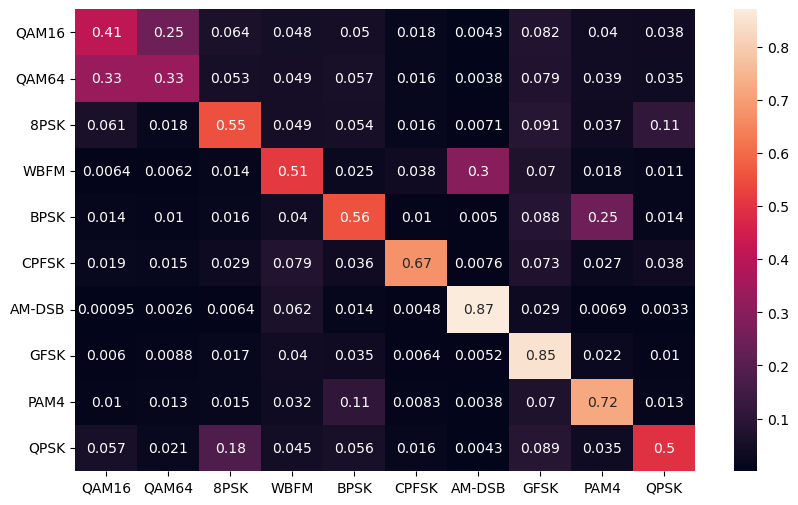

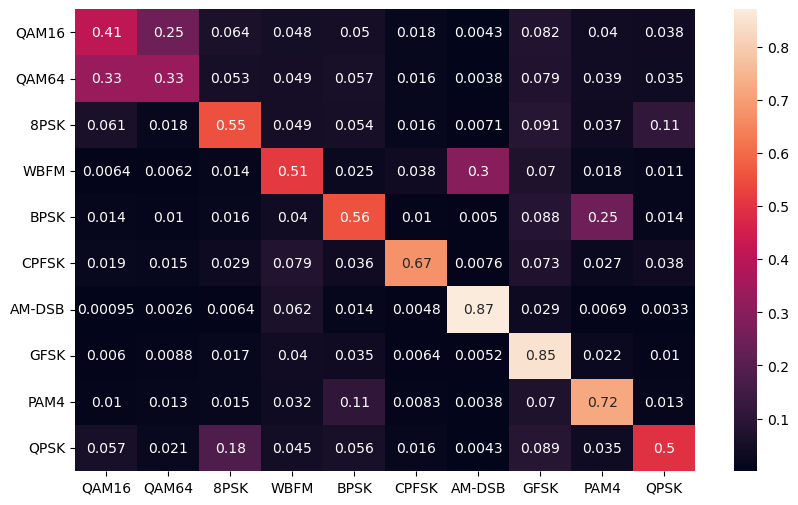

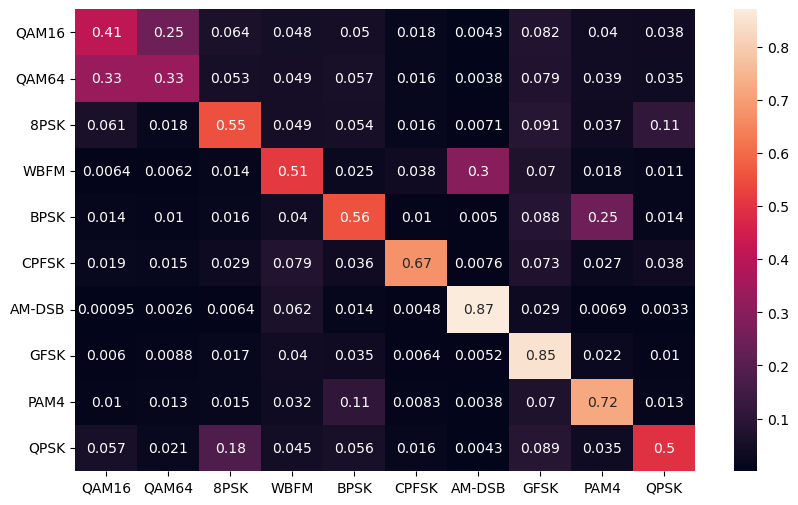

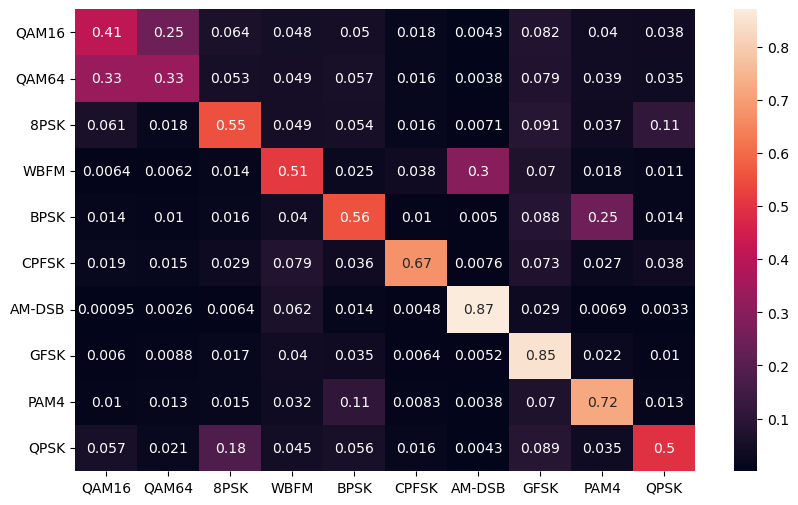

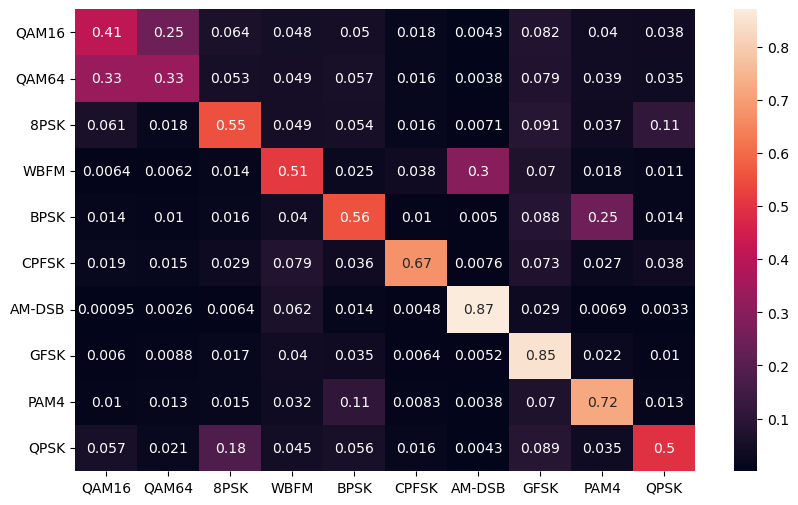

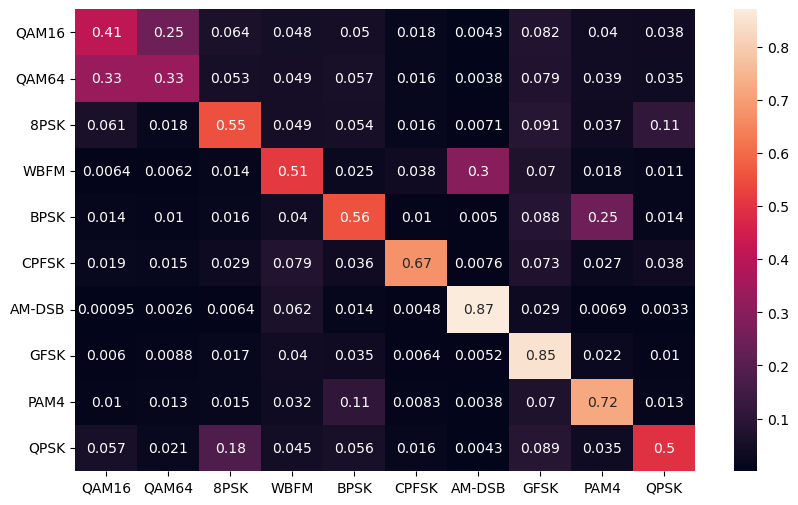

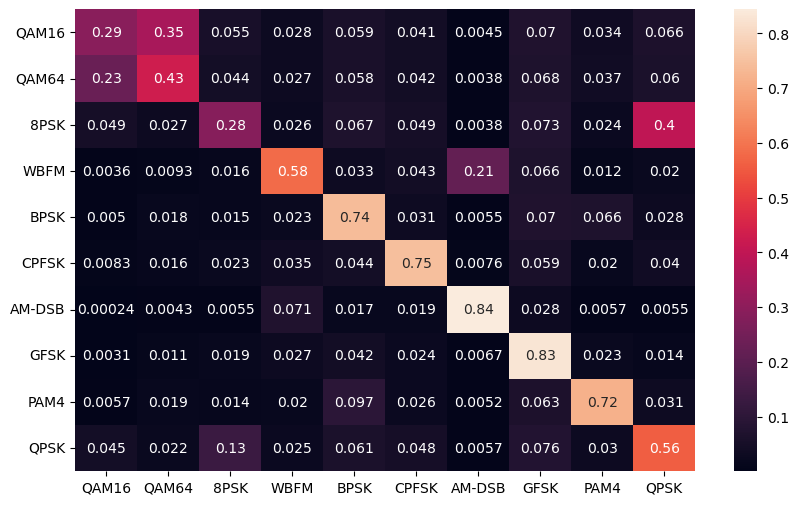

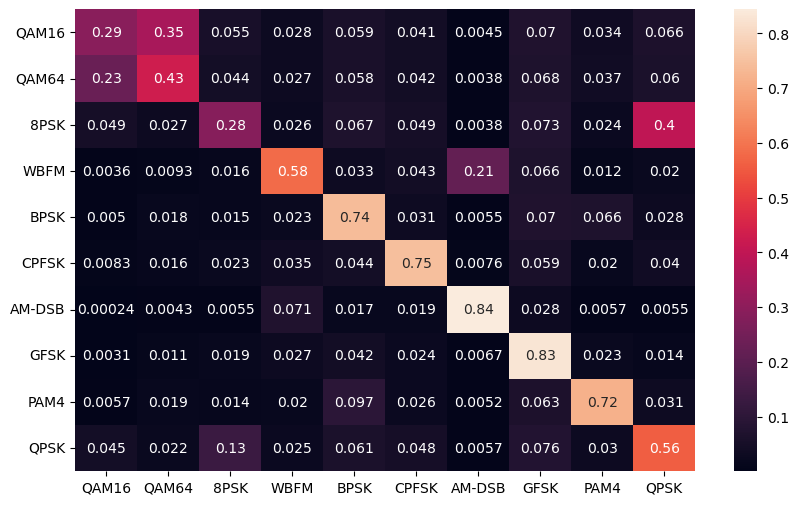

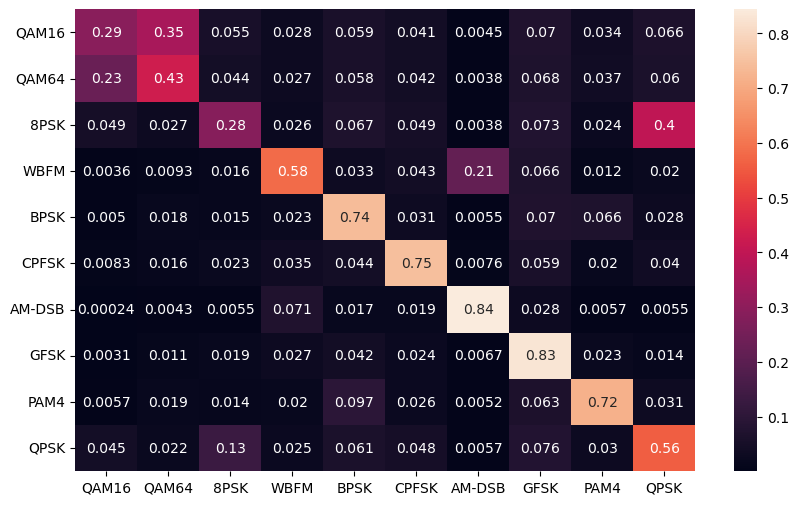

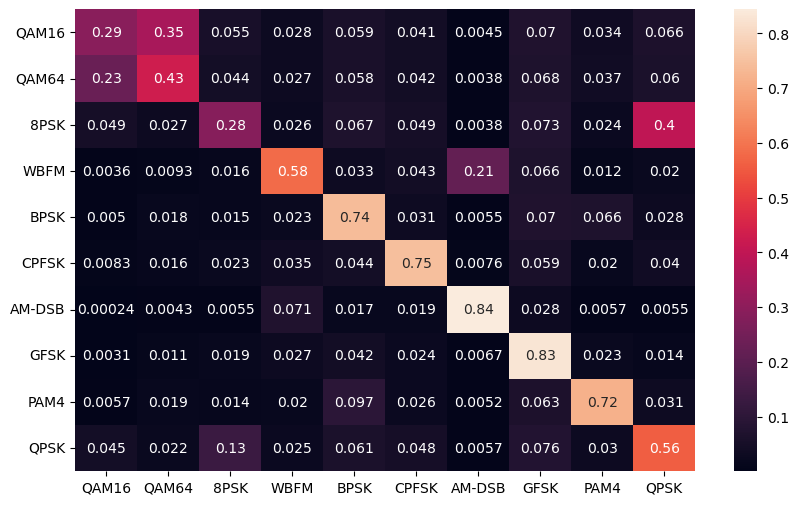

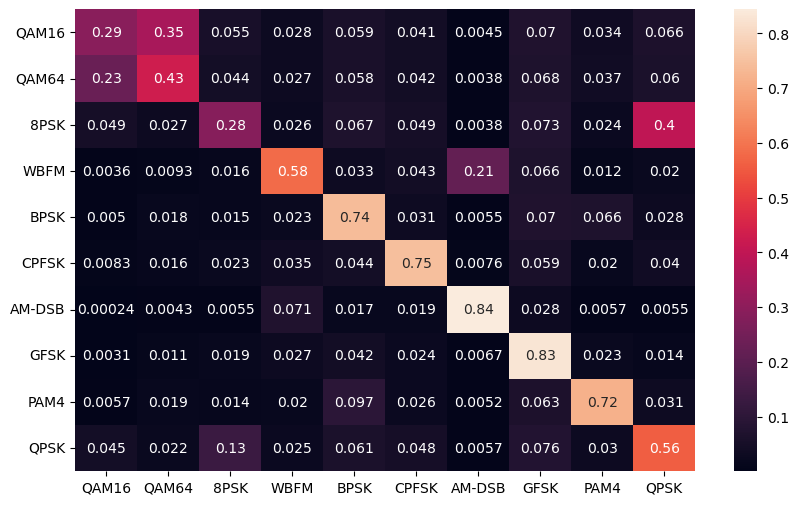

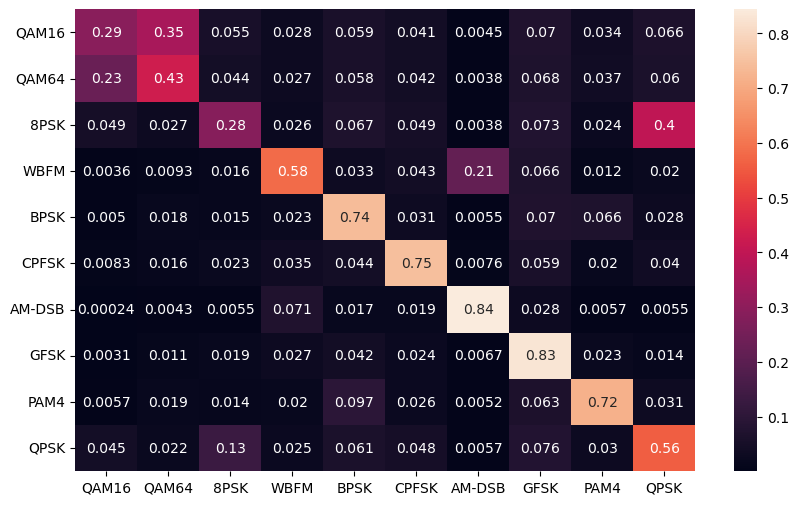

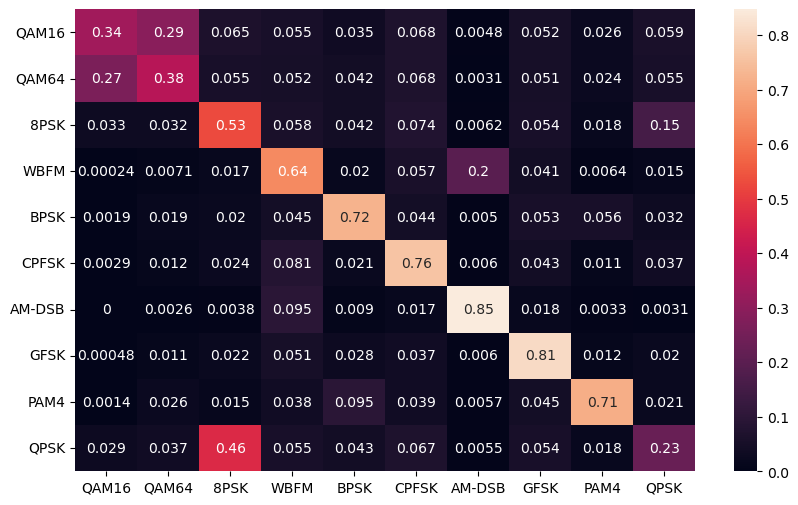

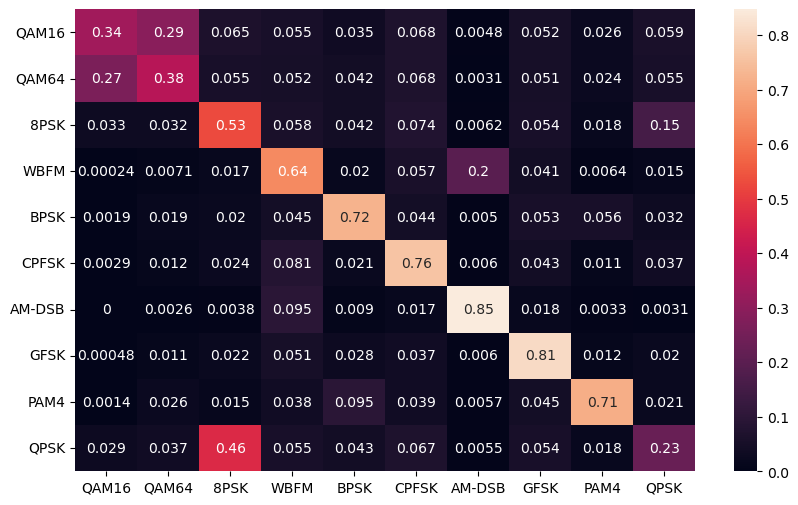

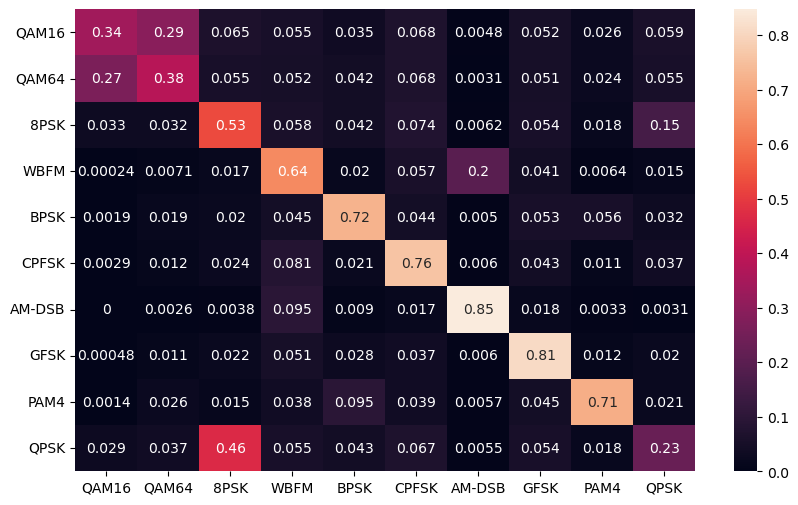

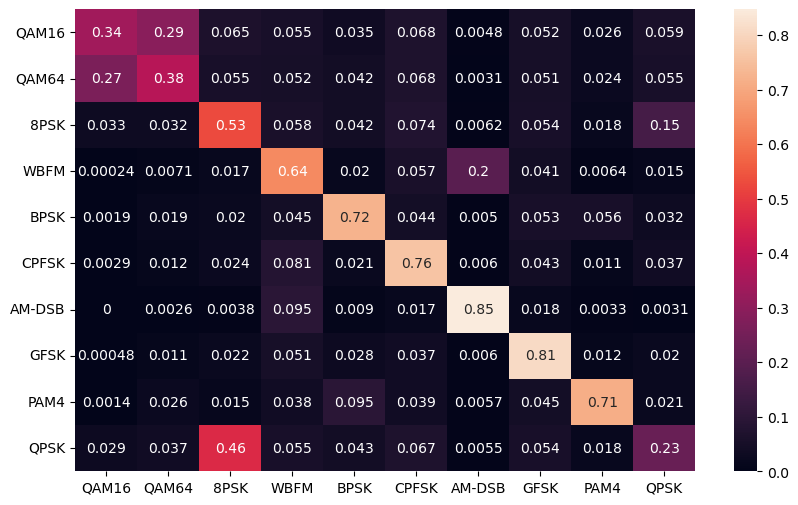

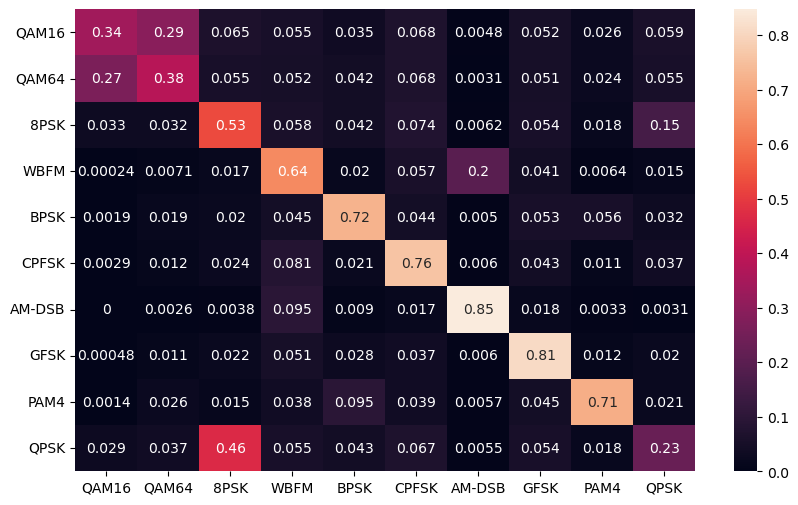

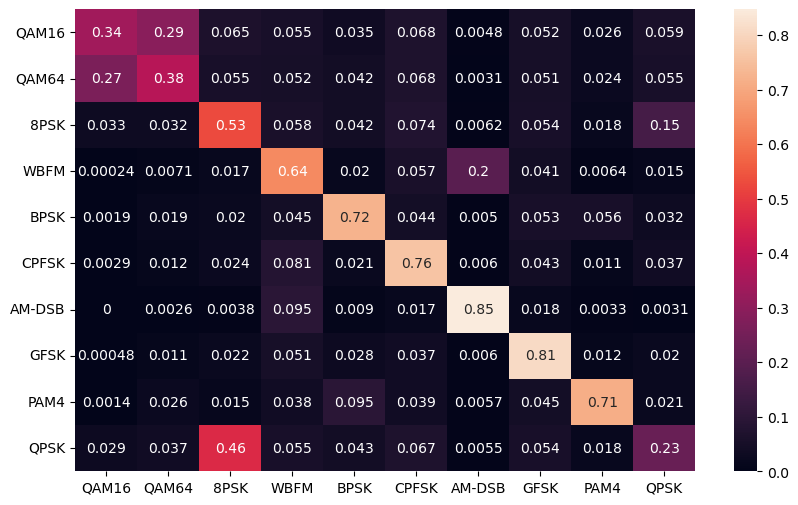

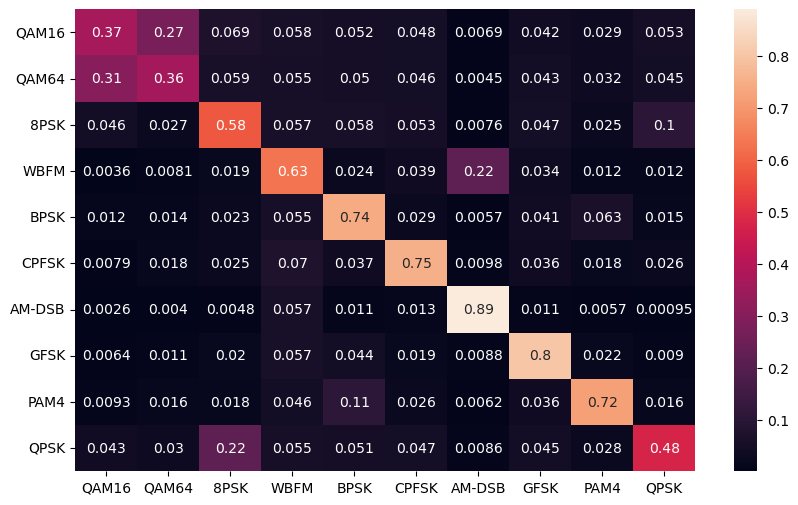

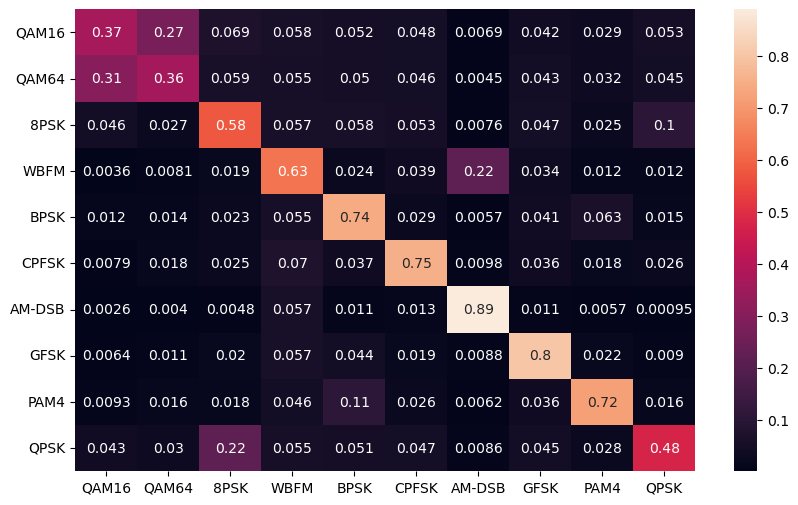

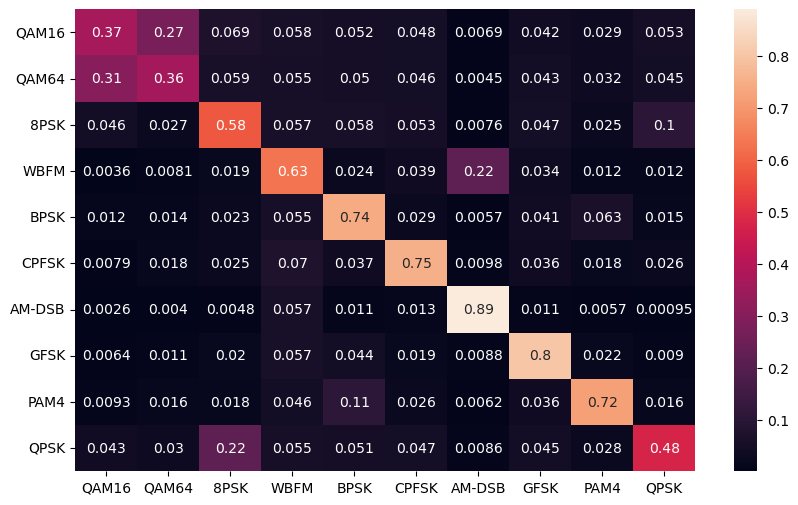

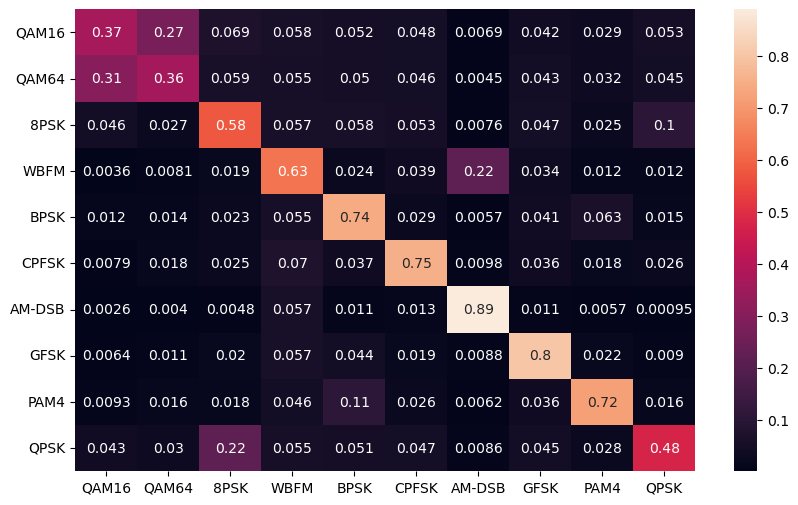

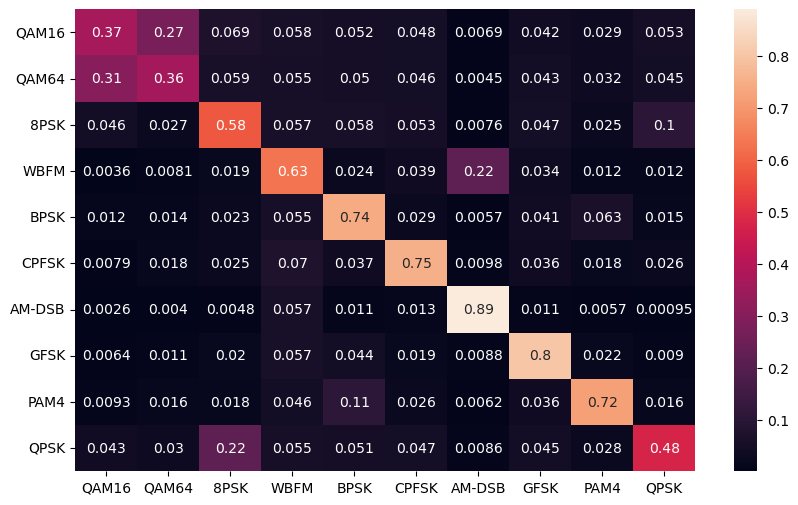

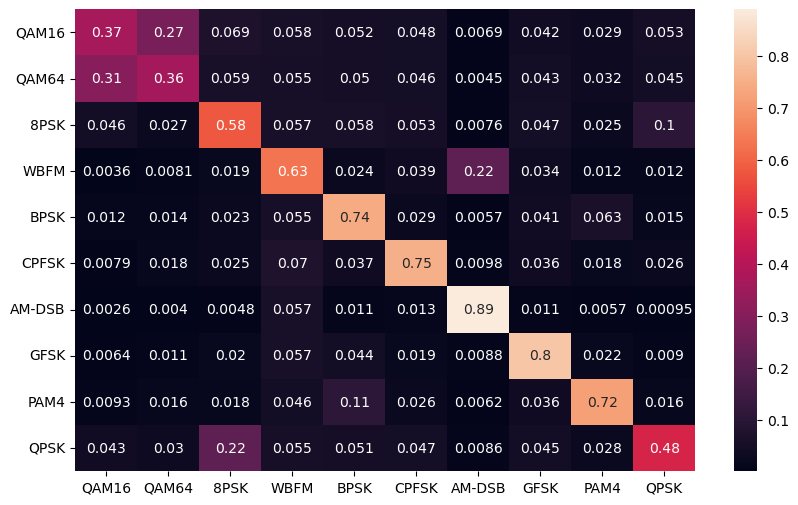

In [148]:
totalPreds = {Version: {thre: [] for thre in thresholds} for Version in ["V0", "V1", "V2", "V3"]}
totalLabels = {Version: {thre: [] for thre in thresholds} for Version in ["V0", "V1", "V2", "V3"]}

for V in ["V0", "V1", "V2", "V3"]:
    for thre in thresholds: 
        for snr in stringSNRs:
            totalPreds[V][thre].extend(predictions[V][THRESHOLD][snr]["preds"].detach().cpu().numpy())
            totalLabels[V][thre].extend(predictions[V][THRESHOLD][snr]["labels"].detach().cpu().numpy())
            
figTitle = "./TestFigures/inference/confusionMats/{}_T{}.png"
thresholds_titles = ['001', '005', '015', '03', '04', '06']
    
for V in ["V0", "V1", "V2", "V3"]:
    for i, thre in enumerate(thresholds):
        getConfusionMatrix(totalPreds[V][thre], totalLabels[V][thre], title=figTitle.format(V, thresholds_titles[i]))
        

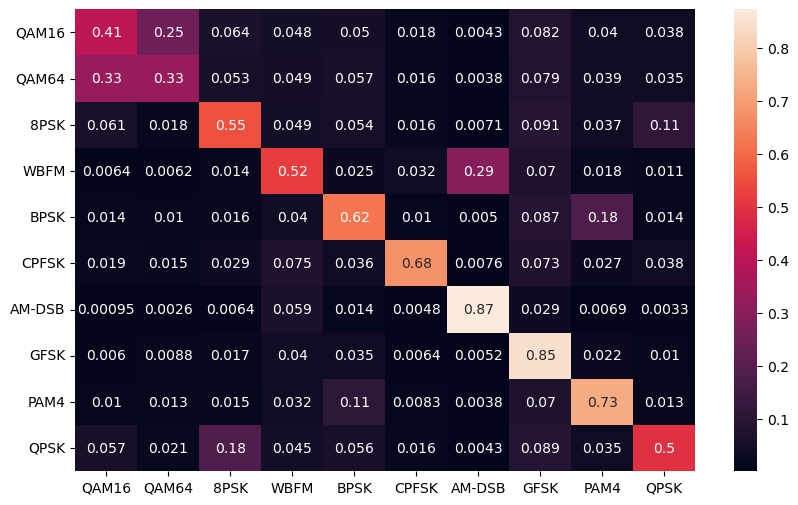

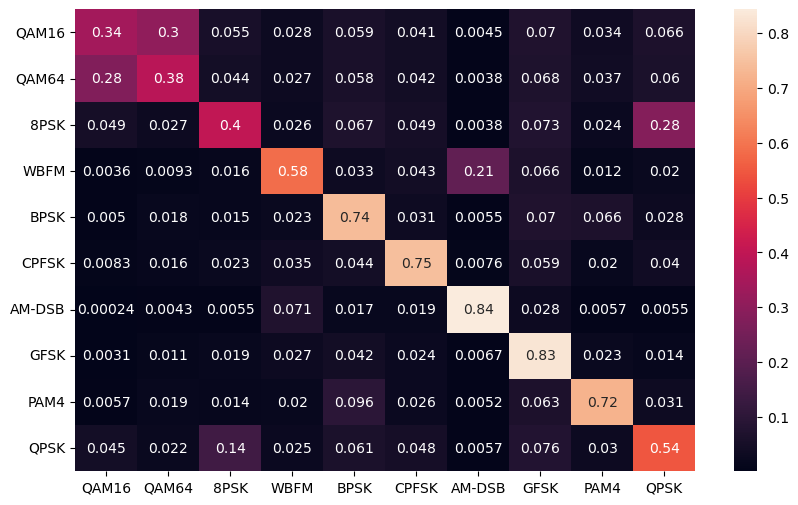

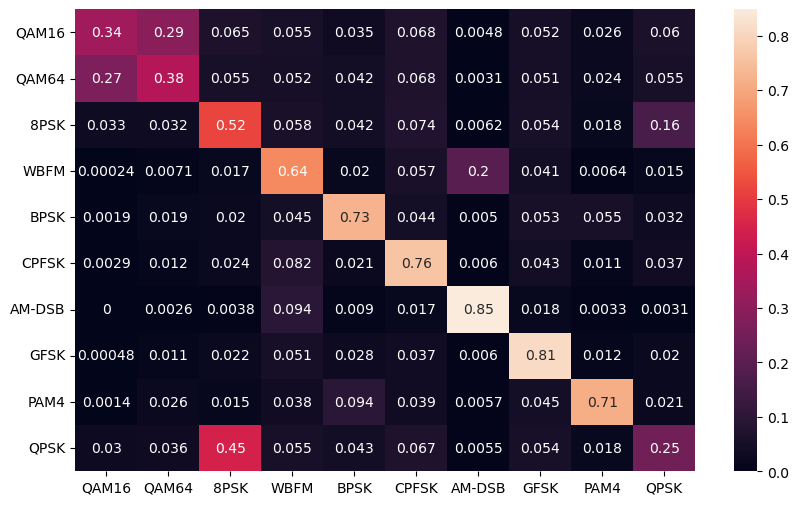

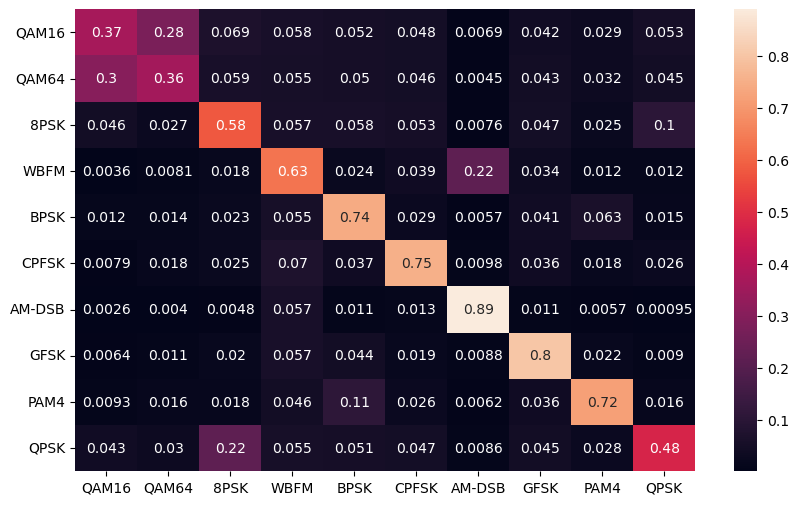

In [167]:
totalPreds2 = {Version: {thre: [] for thre in thresholds} for Version in ["V0", "V1", "V2", "V3"]}
totalLabels2 = {Version: {thre: [] for thre in thresholds} for Version in ["V0", "V1", "V2", "V3"]}

for V in ["V0", "V1", "V2", "V3"]:
    for thre in thresholds: 
        for snr in stringSNRs:
            totalPreds2[V][thre].extend(predictions2[V][0.35][snr]["preds"].detach().cpu().numpy())
            totalLabels2[V][thre].extend(predictions2[V][0.35][snr]["labels"].detach().cpu().numpy())
            
figTitle = './TestFigures/035Results/ConfMat_T035.png'
    
for V in ["V0", "V1", "V2", "V3"]:
    getConfusionMatrix(totalPreds2[V][0.35], totalLabels2[V][0.35], title=figTitle.format(V, "035"))
        

In [164]:
totalPreds2

{'V0': {0.35: [2.0,
   3.0,
   2.0,
   9.0,
   7.0,
   2.0,
   7.0,
   4.0,
   9.0,
   8.0,
   3.0,
   1.0,
   7.0,
   6.0,
   7.0,
   4.0,
   3.0,
   7.0,
   3.0,
   7.0,
   7.0,
   3.0,
   4.0,
   7.0,
   3.0,
   3.0,
   7.0,
   9.0,
   1.0,
   7.0,
   7.0,
   7.0,
   7.0,
   3.0,
   3.0,
   3.0,
   6.0,
   3.0,
   7.0,
   4.0,
   3.0,
   5.0,
   0.0,
   6.0,
   7.0,
   3.0,
   6.0,
   4.0,
   8.0,
   6.0,
   4.0,
   7.0,
   7.0,
   3.0,
   1.0,
   3.0,
   3.0,
   7.0,
   1.0,
   3.0,
   4.0,
   3.0,
   7.0,
   8.0,
   3.0,
   2.0,
   2.0,
   3.0,
   4.0,
   4.0,
   7.0,
   1.0,
   2.0,
   5.0,
   4.0,
   3.0,
   6.0,
   7.0,
   3.0,
   7.0,
   3.0,
   9.0,
   8.0,
   4.0,
   9.0,
   3.0,
   7.0,
   6.0,
   7.0,
   7.0,
   7.0,
   7.0,
   6.0,
   4.0,
   8.0,
   7.0,
   4.0,
   7.0,
   4.0,
   3.0,
   5.0,
   3.0,
   7.0,
   8.0,
   4.0,
   8.0,
   3.0,
   5.0,
   7.0,
   2.0,
   7.0,
   7.0,
   1.0,
   9.0,
   8.0,
   7.0,
   7.0,
   8.0,
   3.0,
   7.0,
   8.0,
   3.0,
   7.0,
   7